In [1]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data preparation

In [2]:
data = pd.read_csv("../data/interim/ratings.csv", index_col=0)
prev_len = len(data)
# take only positive ratings from the users
data = data[data["rating"] >= 3]
print(f"data changed {prev_len} -> {len(data)} with taking only positive")

# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(data.values, test_size=0.2, random_state=16)
train_data = pd.DataFrame(train, columns=data.columns)
test_data = pd.DataFrame(test, columns=data.columns)

print("Train Size  : ", len(train_data))
print("Test Size : ", len(test_data))

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_data["user_id_idx"] = le_user.fit_transform(train_data["user_id"].values)
train_data["item_id_idx"] = le_item.fit_transform(train_data["item_id"].values)

train_user_ids = train_data["user_id"].unique()
train_item_ids = train_data["item_id"].unique()


test_data = test_data[
    (test_data["user_id"].isin(train_user_ids))
    & (test_data["item_id"].isin(train_item_ids))
]

test_data["user_id_idx"] = le_user.transform(test_data["user_id"].values)
test_data["item_id_idx"] = le_item.transform(test_data["item_id"].values)

n_users = train_data["user_id_idx"].nunique()
n_items = train_data["item_id_idx"].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

data changed 100000 -> 82520 with taking only positive
Train Size  :  66016
Test Size :  16504
Number of Unique Users :  943
Number of unique Items :  1546


In [3]:
movies_data = pd.read_csv('../data/interim/items.csv', index_col=0)
movies_data.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [4]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Function to sample negative items not interacted with
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # Grouping interactions by user and creating a DataFrame
    interected_items_df = (
        data.groupby("user_id_idx")["item_id_idx"].apply(list).reset_index()
    )
    indices = [x for x in range(n_usr)]

    # Sampling users for the batch
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users, columns=["users"])

    # Merging user interactions with the selected batch of users
    interected_items_df = pd.merge(
        interected_items_df,
        users_df,
        how="right",
        left_on="user_id_idx",
        right_on="users",
    )

    # Selecting positive items randomly from user interactions
    pos_items = (
        interected_items_df["item_id_idx"].apply(lambda x: random.choice(x)).values
    )

    # Generating negative items for each user
    neg_items = interected_items_df["item_id_idx"].apply(lambda x: sample_neg(x)).values

    # Returning tensors for users, positive items, and negative items
    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr,
    )

In [5]:
u_t = torch.LongTensor(train_data.user_id_idx)
i_t = torch.LongTensor(train_data.item_id_idx) + n_users

train_edge_index = torch.stack((torch.cat([u_t, i_t]), torch.cat([i_t, u_t]))).to(
    device
)

### Model architecture

In [6]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr="add")

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [7]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items,
    ):
        super(RecSysGNN, self).__init__()

        self.embedding = nn.Embedding(num_users + num_items, latent_dim)

        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [8]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (
        (1 / 2)
        * (user_emb0.norm().pow(2) + pos_emb0.norm().pow(2) + neg_emb0.norm().pow(2))
        / float(len(users))
    )

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

### Metric calculation

In [9]:
# make tensor values be from 1 to 5
def rescale_tensor(tensor):
    min_ = tensor.min()
    max_ = tensor.max()
    return 1 + (tensor - min_) / (max_ - min_) * 4

In [10]:
def calculate_rmse(test_data, predicted_ratings):
    true_ranks = []
    pred_ranks = []
    for row in test_data.iterrows():
        row = row[1]
        cur_user = row['user_id_idx']
        cur_item = row['item_id_idx']
        true_ranks.append(row['rating'])
        pred_ranks.append(predicted_ratings[cur_user][cur_item].item())
    mse = mean_squared_error(true_ranks, pred_ranks)
    return np.sqrt(mse)

In [11]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data["user_id_idx"].unique())

    # compute the score of all user-item pairs
    relevance_score = torch.matmul(
        user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1)
    )

    # create dense tensor of all user-item interactions
    i = torch.stack(
        (
            torch.LongTensor(train_data["user_id_idx"].values),
            torch.LongTensor(train_data["item_id_idx"].values),
        )
    )
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = (
        torch.sparse_coo_tensor(i, v, (n_users, n_items)).to_dense().to(device)
    )

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # scale relevance score to make it represent user scores
    predicted_scores = rescale_tensor(relevance_score).detach().cpu()
    # calculate RMSE for test part of the dataset
    # It's use rating difference on true rating given by user
    # and rating predicted by the model
    rmse = calculate_rmse(test_data, predicted_scores)

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(
        topk_relevance_indices.cpu().numpy(),
        columns=["top_indx_" + str(x + 1) for x in range(K)],
    )

    topk_relevance_indices_df["user_ID"] = topk_relevance_indices_df.index
    topk_relevance_indices_df["top_relevant_item"] = topk_relevance_indices_df[
        ["top_indx_" + str(x + 1) for x in range(K)]
    ].values.tolist()

    topk_relevance_indices_df = topk_relevance_indices_df[["user_ID", "top_relevant_item"]]

    # measure overlap between recommended (top-scoring) and held-out user-item
    # interactions
    test_interacted_items = (
        test_data.groupby("user_id_idx")["item_id_idx"].apply(list).reset_index()
    )

    metrics_df = pd.merge(
        test_interacted_items,
        topk_relevance_indices_df,
        how="left",
        left_on="user_id_idx",
        right_on=["user_ID"],
    )
    metrics_df["intrsecting_item"] = [
        list(set(a).intersection(b))
        for a, b in zip(metrics_df.item_id_idx, metrics_df.top_relevant_item)
    ]

    metrics_df["recall"] = metrics_df.apply(
        lambda x: len(x["intrsecting_item"]) / len(x["item_id_idx"]), axis=1
    )
    metrics_df["precision"] = metrics_df.apply(
        lambda x: len(x["intrsecting_item"]) / K, axis=1
    )
    return metrics_df["recall"].mean(), metrics_df["precision"].mean(), rmse

### Train loop

In [12]:
latent_dim = 128
n_layers = 5

EPOCHS = 100
BATCH_SIZE = 512
DECAY = 0.0001
LR = 0.005
K = 20

In [13]:
def train_and_eval(model, optimizer, train_data):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []
    rmse_list = []

    progress = tqdm(range(EPOCHS))
    for epoch in progress:
        n_batch = int(len(train_data) / BATCH_SIZE)
        # track loss history of the training
        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()
            # generate random batch from the training data
            users, pos_items, neg_items = data_loader(
                train_data, BATCH_SIZE, n_users, n_items
            )
            # get the embeddings of the batch data
            (
                users_emb,
                pos_emb,
                neg_emb,
                userEmb0,
                posEmb0,
                negEmb0,
            ) = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            # calculate loss for the model
            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        # eval model of test set
        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision, rmse = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_data, test_data, K
            )

        # mean loss for the epoch
        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))
        rmse_list.append(round(rmse, 4))

        progress.set_description(f"loss: {loss_list_epoch[-1]}, recall: {recall_list[-1]}, rmse: {rmse_list[-1]}")

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list,
        rmse_list
    )

In [14]:
lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2489, 128])]


In [15]:
loss, bpr, reg, recall, precision, rmse  = train_and_eval(
    lightgcn, optimizer, train_data
)

  0%|          | 0/100 [00:00<?, ?it/s]

### Results of the training

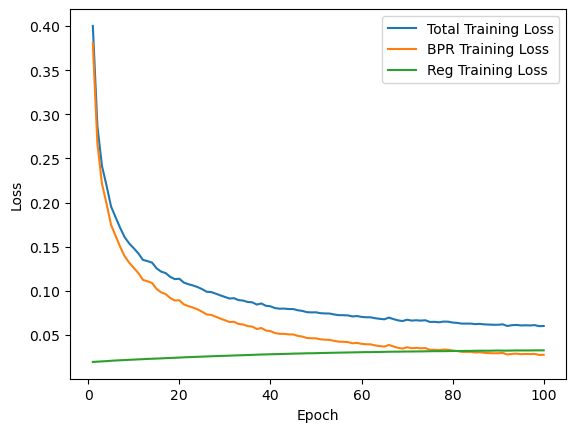

In [16]:
epoch_list = [(i + 1) for i in range(EPOCHS)]
plt.plot(epoch_list, loss, label="Total Training Loss")
plt.plot(epoch_list, bpr, label="BPR Training Loss")
plt.plot(epoch_list, reg, label="Reg Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

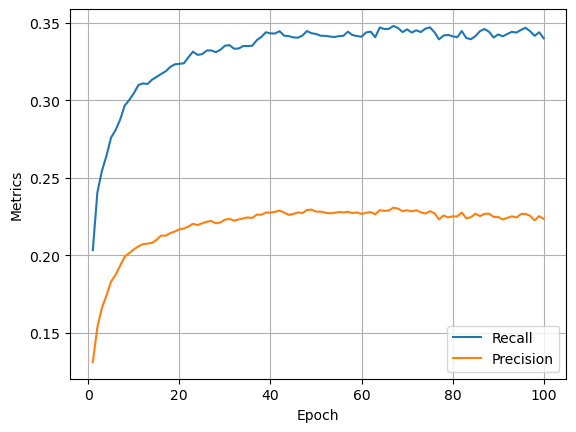

In [17]:
plt.plot(epoch_list, recall, label="Recall")
plt.plot(epoch_list, precision, label="Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.grid()
plt.legend()
plt.show()

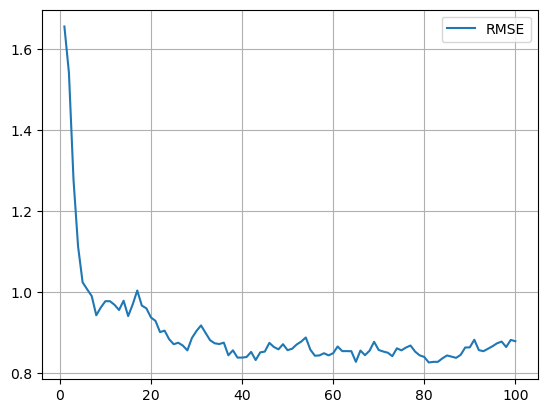

In [18]:
plt.plot(epoch_list, rmse, label="RMSE")
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(lightgcn.state_dict(), '../models/GCN.pt')
torch.save(train_edge_index, "../models/edges.pt")

### Inference

In [26]:
def get_title_by_id(movie_id):
    return movies_data[movies_data['movie_id'] == movie_id]['movie_title'].values[0]


def get_movie_recomendations(user_Embed_wts, item_Embed_wts, user_id, K):
    relevance_score = torch.matmul(
        user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1)
    )
    topk_relevance_indices = torch.topk(relevance_score, K).indices.detach().cpu().numpy()[user_id]
    return movies_data[movies_data['movie_id'].isin(topk_relevance_indices)]['movie_title'].tolist()

def user_inference(user_id, K=20):
    _, out = lightgcn(train_edge_index)
    final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))

    user_data = test_data[test_data['user_id_idx'] == user_id].copy()
    user_data['title'] = user_data['item_id'].apply(get_title_by_id)

    recs = get_movie_recomendations(final_user_Embed, final_item_Embed, user_id, K)
    user_data = user_data[['title', 'rating']]
    print('Movies watched by the user:')
    for m in user_data.iterrows():
        title = m[1]['title']
        r = m[1]['rating']
        print(f"{title} with the rating - {r}")
    print('='*50)
    print("Recomended movies:")
    for i, movie in enumerate(recs):
        print(f"Top {i+1} - {movie}")

In [29]:
user_inference(100, 5)

Movies watched by the user:
Star Wars (1977) with the rating - 4
Dragonheart (1996) with the rating - 3
Hunchback of Notre Dame, The (1996) with the rating - 3
Star Trek: First Contact (1996) with the rating - 3
Juror, The (1996) with the rating - 3
Fly Away Home (1996) with the rating - 3
Courage Under Fire (1996) with the rating - 3
Father of the Bride Part II (1995) with the rating - 3
Long Kiss Goodnight, The (1996) with the rating - 4
Escape from L.A. (1996) with the rating - 3
Recomended movies:
Top 1 - Cold Comfort Farm (1995)
Top 2 - Rock, The (1996)
Top 3 - Striptease (1996)
Top 4 - Batman (1989)
Top 5 - Manhattan Murder Mystery (1993)


In [40]:
def get_movie_scores(user_Embed_wts, item_Embed_wts, user_data):
    relevance_score = torch.matmul(
        user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1)
    )
    predicted_scores = rescale_tensor(relevance_score).detach().cpu()

    user_id = user_data['user_id'].values[0]
    movie_ids = user_data['item_id'].values
    scores = predicted_scores[user_id][movie_ids]
    return scores

def predict_user_scores(user_id):
    _, out = lightgcn(train_edge_index)
    final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))

    user_data = test_data[test_data['user_id_idx'] == user_id].copy()
    user_data['title'] = user_data['item_id'].apply(get_title_by_id)

    recs = get_movie_scores(final_user_Embed, final_item_Embed, user_data)
    user_data['predicted_score'] = recs
    return user_data

predict_user_scores(1)

,user_id,item_id,rating,user_id_idx,item_id_idx,title,predicted_score
147,2,237,4,1,236,Jerry Maguire (1996),2.663246
252,2,277,4,1,276,Restoration (1995),1.981238
522,2,304,4,1,303,Fly Away Home (1996),3.685972
3590,2,275,5,1,274,Sense and Sensibility (1995),2.833648
6722,2,278,3,1,277,Bed of Roses (1996),2.420056
9501,2,281,3,1,280,"River Wild, The (1994)",2.990294
11111,2,242,5,1,241,Kolya (1996),2.782210
11557,2,307,3,1,306,"Devil's Advocate, The (1997)",3.047458
